In [1]:
#!pip install git+https://github.com/alan-turing-institute/SigNet.git
# !pip install --upgrade matplotlib
#!python -m pip install basemap

In [2]:
%matplotlib inline
from SBM_attributed import *
from BregmanFramework import *
from bregman_kmeans import *
from copy import deepcopy
from sklearn.metrics import rand_score, calinski_harabasz_score, mutual_info_score, accuracy_score
from signet.cluster import Cluster
import scipy.sparse as ss
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler

In [3]:
c = 3
n = 100
N = c*n
delta = 10
d = 2
dim = c*d
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])
true_labels = [0]*n + [1]*n + [2]*n

In [4]:
def get_spectral_decomposition(A,c):
		L = csgraph.laplacian(A)
		L = L.astype(np.float32)
		vals = vecs = 0
		vals, vecs = eigs(L, k=(c+1), which='SM', maxiter=5000)
		U = np.delete(vecs,np.argmin(vals),1)
		return U.real

In [5]:
def spectral(A,k):
    U = get_spectral_decomposition(A,k)
    return KMeans(n_clusters=k).fit_predict(U.real)

## Australia Rainfall 

In [6]:
corr_df=pd.read_csv('data/corr_mat.csv',index_col=0)
stat_lat_lon_df = pd.read_csv('data/stations_coords.csv')
stat_lat_lon_df = stat_lat_lon_df.drop(stat_lat_lon_df.columns[[0]],axis=1)
# Create the signed graph 
corr=corr_df.to_numpy()
# Adjacency matrices (positive and negative)
Ap = (corr + abs(corr))/2.
Am = (abs(corr)- corr)/2.
Aps = ss.csc_matrix(Ap)
Ams = ss.csc_matrix(Am)
# Covariates
X = np.array(stat_lat_lon_df,dtype=float)
# x_min = X.min()
# x_max = X.max()
# X = (X - x_min)/(x_max - x_min)

In [7]:
m = Cluster((Aps, Ams))
k=5
predictions = m.SPONGE(k, tau_p=1, tau_n=1, eigens=None, mi=None)
scaler = StandardScaler()
X = scaler.fit_transform(X)
U = get_spectral_decomposition(Ap-Am,k)
U = scaler.fit_transform(U)
bk = BregmanKmeans(divergence_method="euclidean")
W,_= bk.soft_joint_clustering_2_step(Ap-Am,X,k,5)
predictions2 = np.argmax(W, axis=1)
#predictions2 = KMeans(n_clusters=k).fit_predict(W)

point assignments have converged
point assignments have converged


In [8]:
W

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [9]:
# Sort the adjacency matrices
# Compute the permutation (Sponge)
permut =[]
for i in range(k):
    permut= permut+[j for j in range(306) if predictions[j]==i]

# Sort the adjacency matrices
ssortedp = m.p.todense()[permut,:][:,permut]
ssortedn = m.n.todense()[permut,:][:,permut]

# Compute the permutation (BregmanFramework)
permut2 =[]
for i in range(k):
    permut2= permut2+[j for j in range(306) if predictions2[j]==i]
    
# Sort the adjacency matrices
ssortedp2 = m.p.todense()[permut2,:][:,permut2]
ssortedn2 = m.n.todense()[permut2,:][:,permut2]

In [10]:
stations_a = stat_lat_lon_df[["Station"]]
stations_a = stations_a.to_numpy()
stat_lat_lon_a = stat_lat_lon_df.to_numpy()
cmap = matplotlib.cm.get_cmap('tab10')
markers_ = ['o', 'v', '^', '<', '>',  's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8']
# input desired coordinates
my_coords = stat_lat_lon_a[0, 1:3]

# How much to zoom from coordinates (in degrees)
zoom_scale = 20

# Setup the bounding box for the zoom and bounds of the map
bbox = [-46, -8, 110, 158]

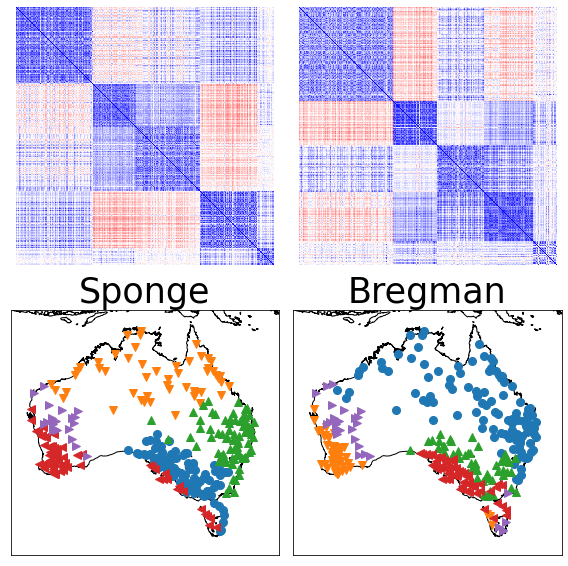

In [11]:
fig, axs = plt.subplots(2, 2,figsize=(8, 8))
axs[0, 0].matshow(ssortedp-ssortedn,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 0].axis('off')
axs[0, 1].matshow(ssortedp2-ssortedn2,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 1].axis('off')

#Second line
axs[1, 0].set_title("Sponge",fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,0])
# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])
    
axs[1, 1].set_title('Bregman',fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions2==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
    
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,1])

# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])

plt.tight_layout()

In [12]:
rand_score(predictions, predictions2),mutual_info_score(predictions,predictions2)

(0.8196507018107789, 0.9766847265782757)

## Equally spaced distributions

In [13]:
pin=0.1
#pouts = np.arange(pout_min,pout_max,0.01)
pouts=[0.01,0.015,0.1]
sigmas=[0.1,1,10]
with open("metrics.txt",'w',encoding = 'utf-8') as f:
    f.write("pout,sigma,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,\
    RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,\
    RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral\n")
    for p_net in pouts:
        P_net = np.eye(3)*pin
        P_net[P_net==0] = p_net
        for sigma in sigmas:
            rs_b = []
            mi_b = []
            rs_k = []
            mi_k = []
            rs_s = []
            mi_s = []
            print(p_net,sigma)
            for _ in range(1):
                G,A,X = generate_benchmark_unit_circle(P_net,c,sigma,n,dim,delta=1)
                X = scaler.fit_transform(X)
                pred_labels = KMeans(n_clusters=c).fit_predict(X)
                rs_k.append(rand_score(true_labels, pred_labels))
                mi_k.append(mutual_info_score(true_labels, pred_labels))
                
                pred_labels = spectral(A,c)
                rs_s.append(rand_score(true_labels, pred_labels))
                mi_s.append(mutual_info_score(true_labels, pred_labels))
                
                U = get_spectral_decomposition(A,c)
                U = scaler.fit_transform(U)
                bk = BregmanKmeans(divergence_method="euclidean")
                #W,mu = bk.soft_clustering(np.hstack([U,X]),3,5)
                W,_ = bk.soft_joint_clustering_2_step(A,X,3,5)
                pred_labels = np.argmax(W, axis=1)
                rs_b.append(rand_score(true_labels, pred_labels))
                mi_b.append(mutual_info_score(true_labels, pred_labels))
            f.write(f"{p_net},{sigma},{np.mean(rs_b)},{np.std(rs_b)},{np.mean(mi_b)},{np.std(mi_b)}\
            ,{np.mean(rs_k)},{np.std(rs_k)},{np.mean(mi_k)},{np.std(mi_k)}\
            ,{np.mean(rs_s)},{np.std(rs_s)},{np.mean(mi_s)},{np.std(mi_s)}\n")

0.01 0.1
point assignments have converged
point assignments have converged
0.01 1
point assignments have converged
point assignments have converged
0.01 10
point assignments have converged
point assignments have converged
0.015 0.1
point assignments have converged
point assignments have converged
0.015 1
point assignments have converged
point assignments have converged
0.015 10
point assignments have converged
point assignments have converged
0.1 0.1
point assignments have converged
point assignments have converged
0.1 1
point assignments have converged
point assignments have converged
0.1 10
point assignments have converged
point assignments have converged


In [14]:
df = pd.read_csv("metrics.txt")
df

,pout,sigma,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral
0,0.010,0.1,1.000000,0.0,1.098612,0.0,0.986778,0.0,1.047099,0.0,0.995563,0.0,1.079912,0.0
1,0.010,1.0,1.000000,0.0,1.098612,0.0,0.703478,0.0,0.314263,0.0,0.995563,0.0,1.079912,0.0
2,0.010,10.0,1.000000,0.0,1.098612,0.0,0.566132,0.0,0.029631,0.0,0.995563,0.0,1.079912,0.0
3,0.015,0.1,0.782051,0.0,0.644062,0.0,0.982520,0.0,1.033253,0.0,0.774872,0.0,0.622468,0.0
4,0.015,1.0,1.000000,0.0,1.098612,0.0,0.720513,0.0,0.353440,0.0,0.774872,0.0,0.622468,0.0
5,0.015,10.0,1.000000,0.0,1.098612,0.0,0.584437,0.0,0.075466,0.0,0.774872,0.0,0.622468,0.0
6,0.100,0.1,0.558841,0.0,0.010642,0.0,0.991171,0.0,1.065799,0.0,0.335585,0.0,0.007335,0.0
7,0.100,1.0,0.560468,0.0,0.016504,0.0,0.691616,0.0,0.292089,0.0,0.335585,0.0,0.007335,0.0
8,0.100,10.0,0.558506,0.0,0.011551,0.0,0.559309,0.0,0.015937,0.0,0.335585,0.0,0.007335,0.0


In [17]:
pin=0.1
#pouts = np.arange(pout_min,pout_max,0.01)
pouts=[0.01,0.015,0.1]
deltas=[0.01,1,10]
with open("metrics_Delta.txt",'w',encoding = 'utf-8') as f:
    f.write("pout,delta,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,\
    RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,\
    RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral\n")
    for p_net in pouts:
        P_net = np.eye(3)*pin
        P_net[P_net==0] = p_net
        for delta in deltas:
            rs_b = []
            mi_b = []
            rs_k = []
            mi_k = []
            rs_s = []
            mi_s = []
            print(delta,p_net)
            for _ in range(1):
                G,A,X = generate_benchmark_unit_circle(P_net,c,1,n,dim,delta)
                X = scaler.fit_transform(X)
                pred_labels = KMeans(n_clusters=c).fit_predict(X)
                rs_k.append(rand_score(true_labels, pred_labels))
                mi_k.append(mutual_info_score(true_labels, pred_labels))
                
                pred_labels = spectral(A,c)
                rs_s.append(rand_score(true_labels, pred_labels))
                mi_s.append(mutual_info_score(true_labels, pred_labels))
                
                U = get_spectral_decomposition(A,c)
                U = scaler.fit_transform(U)
                bk = BregmanKmeans(divergence_method="euclidean")
                W,mu = bk.soft_joint_clustering_2_step(A,X,3,5)
                pred_labels = np.argmax(W, axis=1)
                rs_b.append(rand_score(true_labels, pred_labels))
                mi_b.append(mutual_info_score(true_labels, pred_labels))
            f.write(f"{p_net},{delta},{np.mean(rs_b)},{np.std(rs_b)},{np.mean(mi_b)},{np.std(mi_b)}\
            ,{np.mean(rs_k)},{np.std(rs_k)},{np.mean(mi_k)},{np.std(mi_k)}\
            ,{np.mean(rs_s)},{np.std(rs_s)},{np.mean(mi_s)},{np.std(mi_s)}\n")

0.01 0.01
point assignments have converged
point assignments have converged
1 0.01
point assignments have converged
point assignments have converged
10 0.01
point assignments have converged
point assignments have converged
0.01 0.015
point assignments have converged
point assignments have converged
1 0.015
point assignments have converged
point assignments have converged
10 0.015


/home/felipe/Documentos/BregmanBenchmark/bregman_kmeans.py:180: RuntimeWarning: invalid value encountered in true_divide
  mu = (soft_assignments.T@X)/soft_assignments.sum(axis=0)[:,np.newaxis]


point assignments have converged
point assignments have converged
0.01 0.1
point assignments have converged
point assignments have converged
1 0.1
point assignments have converged
point assignments have converged
10 0.1
point assignments have converged
point assignments have converged


In [18]:
df = pd.read_csv("metrics_Delta.txt")
df

,pout,delta,RandIndexBregman,StdRandBregman,MutualInfoBregman,StdMutualBregman,RandIndexKmeans,StdRandKmeans,MutualInfoKmeans,StdMutualKmeans,RandIndexSpectral,StdRandSpectral,MutualInfoSpectral,StdMutualSpectral
0,0.010,0.01,1.000000,0.0,1.098612,0.0,0.554225,0.0,0.003254,0.0,0.995563,0.0,1.079912,0.0
1,0.010,1.00,1.000000,0.0,1.098612,0.0,0.683300,0.0,0.273979,0.0,0.995563,0.0,1.079912,0.0
2,0.010,10.00,1.000000,0.0,1.098612,0.0,1.000000,0.0,1.098612,0.0,0.991104,0.0,1.061178,0.0
3,0.015,0.01,1.000000,0.0,1.098612,0.0,0.558551,0.0,0.011509,0.0,0.774872,0.0,0.622468,0.0
4,0.015,1.00,1.000000,0.0,1.098612,0.0,0.695630,0.0,0.308332,0.0,0.774872,0.0,0.622468,0.0
5,0.015,10.00,1.000000,0.0,1.098612,0.0,1.000000,0.0,1.098612,0.0,0.774872,0.0,0.622468,0.0
6,0.100,0.01,0.557815,0.0,0.008930,0.0,0.555920,0.0,0.007200,0.0,0.335585,0.0,0.007335,0.0
7,0.100,1.00,0.556678,0.0,0.009025,0.0,0.675072,0.0,0.253839,0.0,0.335585,0.0,0.007335,0.0
8,0.100,10.00,0.558149,0.0,0.010772,0.0,1.000000,0.0,1.098612,0.0,0.335585,0.0,0.007335,0.0
